In [1]:
!pip install -q efficientnet
!pip install -q pyyaml h5py
# !pip install --upgrade tensorflow
# !pip install --upgrade tensorflow-gpu
#basic libraries
import os, re, math, cv2, json, warnings, itertools
import numpy as np
import pandas as pd
from pathlib import Path
from pandas_profiling import ProfileReport

#plot libraries
import matplotlib.pyplot as plt
import plotly.express as px
from tqdm import tqdm
#utilities library
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, auc, precision_recall_curve, plot_precision_recall_curve, confusion_matrix

#background library for learning 
import tensorflow as tf
import tensorflow.keras.layers as L
# Model
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks

from tensorflow.keras.optimizers import Adam
from datetime import datetime, date
import tensorflow.keras.backend as K
from tensorflow.keras.applications.vgg16 import VGG16
from pandas_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from kaggle_datasets import KaggleDatasets

import efficientnet.tfkeras as efn

2021-11-27 23:07:07.250101: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-11-27 23:07:07.250209: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)


Running on TPU  grpc://10.0.0.2:8470


2021-11-27 23:07:11.881450: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-11-27 23:07:11.884317: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-11-27 23:07:11.884345: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-11-27 23:07:11.884370: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (eac3e80ddb4e): /proc/driver/nvidia/version does not exist
2021-11-27 23:07:11.886658: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

REPLICAS:  8


In [3]:
BASE_PATH = '../input/siim-isic-melanoma-classification'
PATH_TO_IMAGES = '../input/siim-isic-melanoma-classification/jpeg' 
IMAGE_TYPE = ".jpg"

# Read files
train_df = pd.read_csv(BASE_PATH + '/train.csv')
test_df  = pd.read_csv(BASE_PATH +'/test.csv')

In [4]:
print('Training set contains {} images of {} unique patients, resulting in a ratio of {} images per patient'.format(train_df.shape[0],
                                                                                                                     train_df.patient_id.nunique(),
                                                                                                                     round(train_df.shape[0] / train_df.patient_id.nunique(),2)
                                                                                                                    ))

print('Testing  set contains {} images of {}  unique patients, resulting in a ratio of {} images per patient'.format(test_df.shape[0],
                                                                                                                 test_df.patient_id.nunique(),
                                                                                                                 round(test_df.shape[0] / test_df.patient_id.nunique(),2)
                                                                                                                ))

Training set contains 33126 images of 2056 unique patients, resulting in a ratio of 16.11 images per patient
Testing  set contains 10982 images of 690  unique patients, resulting in a ratio of 15.92 images per patient


In [5]:
train_df = train_df.dropna()

In [6]:
# For tf.dataset Tensorflow tf. data AUTOTUNE. ... prefetch transformation, 
# which can be used to decouple the time when data is produced from the time when data is consumed. 
# In particular, the transformation uses a background thread and an internal buffer to prefetch 
# elements from the input dataset ahead of the time they are requested.
AUTO = tf.data.experimental.AUTOTUNE

# Get data access to the dataset for TPUs
GCS_PATH = KaggleDatasets().get_gcs_path('siim-isic-melanoma-classification')

# Running Configuration 
EPOCHS = 2
BATCH_SIZE = 8 * strategy.num_replicas_in_sync
IMAGE_SIZE = [1024, 1024]

# Listing the filenames in TFRecords fomat
TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/tfrecords/train*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/tfrecords/test*.tfrec')
CLASSES = [0,1]
print('Training filenames\n', TRAINING_FILENAMES)
print('Test file names\n', TEST_FILENAMES)

Training filenames
 ['gs://kds-76608ae531879c8da7d92afcf1fc8c09677f8b746b3c9292475cafcc/tfrecords/train00-2071.tfrec', 'gs://kds-76608ae531879c8da7d92afcf1fc8c09677f8b746b3c9292475cafcc/tfrecords/train01-2071.tfrec', 'gs://kds-76608ae531879c8da7d92afcf1fc8c09677f8b746b3c9292475cafcc/tfrecords/train02-2071.tfrec', 'gs://kds-76608ae531879c8da7d92afcf1fc8c09677f8b746b3c9292475cafcc/tfrecords/train03-2071.tfrec', 'gs://kds-76608ae531879c8da7d92afcf1fc8c09677f8b746b3c9292475cafcc/tfrecords/train04-2071.tfrec', 'gs://kds-76608ae531879c8da7d92afcf1fc8c09677f8b746b3c9292475cafcc/tfrecords/train05-2071.tfrec', 'gs://kds-76608ae531879c8da7d92afcf1fc8c09677f8b746b3c9292475cafcc/tfrecords/train06-2071.tfrec', 'gs://kds-76608ae531879c8da7d92afcf1fc8c09677f8b746b3c9292475cafcc/tfrecords/train07-2071.tfrec', 'gs://kds-76608ae531879c8da7d92afcf1fc8c09677f8b746b3c9292475cafcc/tfrecords/train08-2071.tfrec', 'gs://kds-76608ae531879c8da7d92afcf1fc8c09677f8b746b3c9292475cafcc/tfrecords/train09-2071.tfrec',

2021-11-27 23:07:18.488138: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2021-11-27 23:07:18.568717: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


In [7]:
VALIDATION_FILENAMES =list(pd.Series(TRAINING_FILENAMES)[[0,1,2]])
TRAINING_FILENAMES = list(pd.Series(TRAINING_FILENAMES)[[3,4,5,6,7,8,9,10,11,12,13,14,15]])
print(TRAINING_FILENAMES)
print(VALIDATION_FILENAMES)

['gs://kds-76608ae531879c8da7d92afcf1fc8c09677f8b746b3c9292475cafcc/tfrecords/train03-2071.tfrec', 'gs://kds-76608ae531879c8da7d92afcf1fc8c09677f8b746b3c9292475cafcc/tfrecords/train04-2071.tfrec', 'gs://kds-76608ae531879c8da7d92afcf1fc8c09677f8b746b3c9292475cafcc/tfrecords/train05-2071.tfrec', 'gs://kds-76608ae531879c8da7d92afcf1fc8c09677f8b746b3c9292475cafcc/tfrecords/train06-2071.tfrec', 'gs://kds-76608ae531879c8da7d92afcf1fc8c09677f8b746b3c9292475cafcc/tfrecords/train07-2071.tfrec', 'gs://kds-76608ae531879c8da7d92afcf1fc8c09677f8b746b3c9292475cafcc/tfrecords/train08-2071.tfrec', 'gs://kds-76608ae531879c8da7d92afcf1fc8c09677f8b746b3c9292475cafcc/tfrecords/train09-2071.tfrec', 'gs://kds-76608ae531879c8da7d92afcf1fc8c09677f8b746b3c9292475cafcc/tfrecords/train10-2071.tfrec', 'gs://kds-76608ae531879c8da7d92afcf1fc8c09677f8b746b3c9292475cafcc/tfrecords/train11-2071.tfrec', 'gs://kds-76608ae531879c8da7d92afcf1fc8c09677f8b746b3c9292475cafcc/tfrecords/train12-2071.tfrec', 'gs://kds-76608ae53

In [8]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        #"class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
        "target": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    #label = tf.cast(example['class'], tf.int32)
    label = tf.cast(example['target'], tf.int32)
    return image, label # returns a dataset of (image, label) pairs

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "image_name": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
        # class is missing, this challenge is to predict flower classes for the test dataset
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['image_name']
    return image, idnum # returns a dataset of image(s)

def load_dataset(filenames, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls=AUTO)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset


def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(ordered=False):
    dataset = load_dataset(VALIDATION_FILENAMES, labeled=True, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_test_dataset(ordered=False):
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)


In [9]:
def data_augment(image, label):
    # data augmentation. Thanks to the dataset.prefetch(AUTO) statement in the next function (above),
    # this happens essentially for free on TPU. Data pipeline code is executed on the "CPU" part
    # of the TPU while the TPU itself is computing gradients.
    image = tf.image.random_flip_left_right(image)
#     image = tf.image.random_flip_up_down(image)
    #image = tf.image.random_saturation(image, 0, 2)
    return image, label   


Dataset Details:
26913 training images,  
6213 validation images 
10982 unlabeled test images


<Figure size 432x288 with 0 Axes>

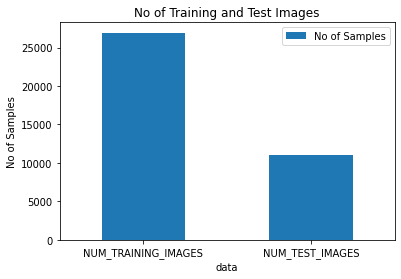

In [10]:
NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)
NUM_VALID_IMAGES = count_data_items(VALIDATION_FILENAMES)
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE

print('Dataset Details:\n{} training images,  \n{} validation images \n{} unlabeled test images'.format(NUM_TRAINING_IMAGES, NUM_VALID_IMAGES, NUM_TEST_IMAGES))


df = pd.DataFrame({'data':['NUM_TRAINING_IMAGES', 'NUM_TEST_IMAGES'],
                   'No of Samples':[NUM_TRAINING_IMAGES, NUM_TEST_IMAGES]})
plt.figure()
x = df.plot.bar(x='data', y='No of Samples', rot=0)
plt.ylabel('No of Samples')
plt.title('No of Training and Test Images')
plt.show()

In [11]:
def build_lrfn(lr_start=0.000002, lr_max=0.00010, 
               lr_min=0, lr_rampup_epochs=8, 
               lr_sustain_epochs=1, lr_exp_decay=.8):

    def lrfn(epoch):
        if epoch < lr_rampup_epochs:
            lr = (lr_max - lr_start) / lr_rampup_epochs * epoch + lr_start
        elif epoch < lr_rampup_epochs + lr_sustain_epochs:
            lr = lr_max
        else:
            lr = (lr_max - lr_min) *\
                 lr_exp_decay**(epoch - lr_rampup_epochs\
                                - lr_sustain_epochs) + lr_min
        return lr
    return lrfn

lrfn = build_lrfn()
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

In [12]:
train_dataset = get_training_dataset()
valid_dataset = get_validation_dataset()

In [13]:
TRAINING = True # set to True if you wanna train ze models!

In [14]:
if TRAINING:
    with strategy.scope():
        model = tf.keras.Sequential([
            efn.EfficientNetB7(
                input_shape=(*IMAGE_SIZE, 3),
                weights='imagenet',
                include_top=False
            ),
            L.GlobalAveragePooling2D(),
            L.Dense(1, activation='sigmoid')
        ])
        model.compile(
            optimizer='adam',
            loss = 'binary_crossentropy',
            metrics=['accuracy']
        )
        model.summary()

258441216/258434480 [==============================] - 5s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b7 (Functional) (None, 32, 32, 2560)      64097680  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2560)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2561      
Total params: 64,100,241
Trainable params: 63,789,521
Non-trainable params: 310,720
_________________________________________________________________


In [15]:
from tensorflow.keras.applications import DenseNet201

if TRAINING:
    with strategy.scope():
        dnet201 = DenseNet201(
            input_shape=(*IMAGE_SIZE, 3),
            weights='imagenet',
            include_top=False
        )
        dnet201.trainable = False

        model2 = tf.keras.Sequential([
            dnet201,
            L.GlobalAveragePooling2D(),
            L.Dense(1, activation='sigmoid')
        ])
        model2.compile(
            optimizer='adam',
            loss = 'binary_crossentropy',
            metrics=['accuracy']
        )

    model2.summary()

74842112/74836368 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 32, 32, 1920)      18321984  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1920)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1921      
Total params: 18,323,905
Trainable params: 1,921
Non-trainable params: 18,321,984
_________________________________________________________________


In [16]:
if TRAINING:
    history = model.fit(
        train_dataset, 
        epochs=EPOCHS, 
        callbacks=[lr_schedule],
        steps_per_epoch=STEPS_PER_EPOCH,
        validation_data=valid_dataset
    )
    model.save("efficientnetb7.h5")

Epoch 1/2

Epoch 00001: LearningRateScheduler reducing learning rate to 2e-06.
420/420 [==============================] - 1118s 2s/step - loss: 0.5826 - accuracy: 0.7914 - val_loss: 0.2088 - val_accuracy: 0.9837


2021-11-27 23:27:20.398733: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 151088, Output num: 1
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1638055640.395295564","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 151088, Output num: 1","grpc_status":3}


Epoch 2/2

Epoch 00002: LearningRateScheduler reducing learning rate to 1.425e-05.
420/420 [==============================] - 832s 2s/step - loss: 0.1099 - accuracy: 0.9801 - val_loss: 0.0713 - val_accuracy: 0.9837


In [17]:
if TRAINING:
    history2 = model2.fit(
        train_dataset, 
        epochs=EPOCHS, 
        callbacks=[lr_schedule],
        steps_per_epoch=STEPS_PER_EPOCH,
        validation_data=valid_dataset
    )
    model2.save("densenet201.h5")

Epoch 1/2

Epoch 00001: LearningRateScheduler reducing learning rate to 2e-06.
420/420 [==============================] - 319s 668ms/step - loss: 0.6230 - accuracy: 0.6883 - val_loss: 0.5516 - val_accuracy: 0.8386


2021-11-27 23:46:46.060152: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 170759, Output num: 1
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1638056806.059963400","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 170759, Output num: 1","grpc_status":3}


Epoch 2/2

Epoch 00002: LearningRateScheduler reducing learning rate to 1.425e-05.
420/420 [==============================] - 242s 577ms/step - loss: 0.4384 - accuracy: 0.9330 - val_loss: 0.2350 - val_accuracy: 0.9837


In [18]:
# get the current timestamp. This timestamp is used to save the model data with a unique name
now = datetime.now()
today = date.today()
current_time = now.strftime("%H:%M:%S")
timestamp = str(today) + "_" + str(current_time)

In [19]:
def display_training_curves(training, validation, title, subplot):
    """
    Source: https://www.kaggle.com/mgornergoogle/getting-started-with-100-flowers-on-tpu
    """
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

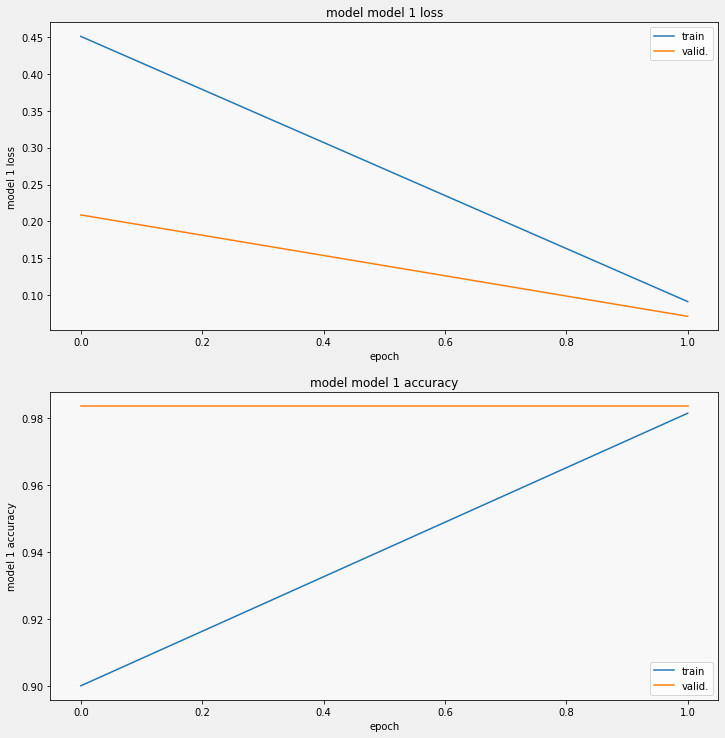

In [20]:
if TRAINING:
    display_training_curves(
        history.history['loss'], 
        history.history['val_loss'], 
        'model 1 loss', 211)
    display_training_curves(
        history.history['accuracy'], 
        history.history['val_accuracy'], 
        'model 1 accuracy', 212)

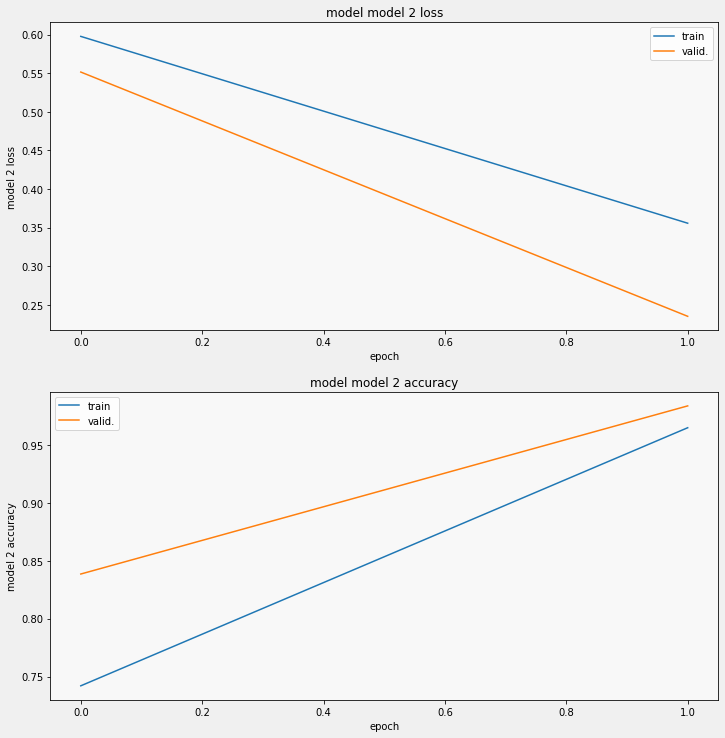

In [21]:
if TRAINING:
    display_training_curves(
        history2.history['loss'], 
        history2.history['val_loss'], 
        'model 2 loss', 211)
    display_training_curves(
        history2.history['accuracy'], 
        history2.history['val_accuracy'], 
        'model 2 accuracy', 212)

In [22]:
# if TRAINING:
#     display_training_curves(
#         history.history['loss'], 
#         history.history['val_loss'], 
#         'model 1 loss', 211)
#     display_training_curves(
#         history.history['accuracy'], 
#         history.history['val_accuracy'], 
#         'model 1 accuracy', 212)s_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U') # all in one batch

In [23]:
import os, random, re, math, time
random.seed(a=42)

import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow.keras.backend as K
import efficientnet.tfkeras as efn

import PIL

from kaggle_datasets import KaggleDatasets

from tqdm import tqdm

In [24]:
DEVICE = "TPU"

CFG = dict(
    net_count         =   7,
    batch_size        =  16,
    
    read_size         = 256, 
    crop_size         = 250, 
    net_size          = 224, 
    
    LR_START          =   0.000005,
    LR_MAX            =   0.000020,
    LR_MIN            =   0.000001,
    LR_RAMPUP_EPOCHS  =   5,
    LR_SUSTAIN_EPOCHS =   0,
    LR_EXP_DECAY      =   0.8,
    epochs            =  12,
    
    rot               = 180.0,
    shr               =   2.0,
    hzoom             =   8.0,
    wzoom             =   8.0,
    hshift            =   8.0,
    wshift            =   8.0,

    optimizer         = 'adam',
    label_smooth_fac  =   0.05,
    
    tta_steps         =  25    
)

In [25]:
BASEPATH = "../input/siim-isic-melanoma-classification"
df_train = pd.read_csv(os.path.join(BASEPATH, 'train.csv'))
df_test  = pd.read_csv(os.path.join(BASEPATH, 'test.csv'))

GCS_PATH    = KaggleDatasets().get_gcs_path('melanoma-256x256')
files_train = np.sort(np.array(tf.io.gfile.glob(GCS_PATH + '/train*.tfrec')))
files_test  = np.sort(np.array(tf.io.gfile.glob(GCS_PATH + '/test*.tfrec')))

2021-11-27 23:51:05.615015: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2021-11-27 23:51:05.685905: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


In [26]:
if DEVICE == "TPU":
    print("connecting to TPU...")
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Running on TPU ', tpu.master())
    except ValueError:
        print("Could not connect to TPU")
        tpu = None

    if tpu:
        try:
            print("initializing  TPU ...")
            tf.config.experimental_connect_to_cluster(tpu)
            tf.tpu.experimental.initialize_tpu_system(tpu)
            strategy = tf.distribute.experimental.TPUStrategy(tpu)
            print("TPU initialized")
        except _:
            print("failed to initialize TPU")
    else:
        DEVICE = "GPU"

if DEVICE != "TPU":
    print("Using default strategy for CPU and single GPU")
    strategy = tf.distribute.get_strategy()

if DEVICE == "GPU":
    print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
    

AUTO     = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')

connecting to TPU...
Running on TPU  grpc://10.0.0.2:8470
initializing  TPU ...


2021-11-27 23:51:06.926690: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2021-11-27 23:51:06.926753: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30019}
2021-11-27 23:51:06.931471: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2021-11-27 23:51:06.931517: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30019}


TPU initialized
REPLICAS: 8


In [27]:
def get_mat(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    # returns 3x3 transformmatrix which transforms indicies
        
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    shear    = math.pi * shear    / 180.

    def get_3x3_mat(lst):
        return tf.reshape(tf.concat([lst],axis=0), [3,3])
    
    # ROTATION MATRIX
    c1   = tf.math.cos(rotation)
    s1   = tf.math.sin(rotation)
    one  = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    
    rotation_matrix = get_3x3_mat([c1,   s1,   zero, 
                                   -s1,  c1,   zero, 
                                   zero, zero, one])    
    # SHEAR MATRIX
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)    
    
    shear_matrix = get_3x3_mat([one,  s2,   zero, 
                                zero, c2,   zero, 
                                zero, zero, one])        
    # ZOOM MATRIX
    zoom_matrix = get_3x3_mat([one/height_zoom, zero,           zero, 
                               zero,            one/width_zoom, zero, 
                               zero,            zero,           one])    
    # SHIFT MATRIX
    shift_matrix = get_3x3_mat([one,  zero, height_shift, 
                                zero, one,  width_shift, 
                                zero, zero, one])
    
    return K.dot(K.dot(rotation_matrix, shear_matrix), 
                 K.dot(zoom_matrix,     shift_matrix))


def transform(image, cfg):    
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated, sheared, zoomed, and shifted
    DIM = cfg["read_size"]
    XDIM = DIM%2 #fix for size 331
    
    rot = cfg['rot'] * tf.random.normal([1], dtype='float32')
    shr = cfg['shr'] * tf.random.normal([1], dtype='float32') 
    h_zoom = 1.0 + tf.random.normal([1], dtype='float32') / cfg['hzoom']
    w_zoom = 1.0 + tf.random.normal([1], dtype='float32') / cfg['wzoom']
    h_shift = cfg['hshift'] * tf.random.normal([1], dtype='float32') 
    w_shift = cfg['wshift'] * tf.random.normal([1], dtype='float32') 

    # GET TRANSFORMATION MATRIX
    m = get_mat(rot,shr,h_zoom,w_zoom,h_shift,w_shift) 

    # LIST DESTINATION PIXEL INDICES
    x   = tf.repeat(tf.range(DIM//2, -DIM//2,-1), DIM)
    y   = tf.tile(tf.range(-DIM//2, DIM//2), [DIM])
    z   = tf.ones([DIM*DIM], dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(m, tf.cast(idx, dtype='float32'))
    idx2 = K.cast(idx2, dtype='int32')
    idx2 = K.clip(idx2, -DIM//2+XDIM+1, DIM//2)
    
    # FIND ORIGIN PIXEL VALUES           
    idx3 = tf.stack([DIM//2-idx2[0,], DIM//2-1+idx2[1,]])
    d    = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM, DIM,3])

In [28]:
def read_labeled_tfrecord(example):
    tfrec_format = {
        'image'                        : tf.io.FixedLenFeature([], tf.string),
        'image_name'                   : tf.io.FixedLenFeature([], tf.string),
        'patient_id'                   : tf.io.FixedLenFeature([], tf.int64),
        'sex'                          : tf.io.FixedLenFeature([], tf.int64),
        'age_approx'                   : tf.io.FixedLenFeature([], tf.int64),
        'anatom_site_general_challenge': tf.io.FixedLenFeature([], tf.int64),
        'diagnosis'                    : tf.io.FixedLenFeature([], tf.int64),
        'target'                       : tf.io.FixedLenFeature([], tf.int64)
    }           
    example = tf.io.parse_single_example(example, tfrec_format)
    return example['image'], example['target']


def read_unlabeled_tfrecord(example, return_image_name):
    tfrec_format = {
        'image'                        : tf.io.FixedLenFeature([], tf.string),
        'image_name'                   : tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, tfrec_format)
    return example['image'], example['image_name'] if return_image_name else 0

 
def prepare_image(img, cfg=None, augment=True):    
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [cfg['read_size'], cfg['read_size']])
    img = tf.cast(img, tf.float32) / 255.0
    
    if augment:
        img = transform(img, cfg)
        img = tf.image.random_crop(img, [cfg['crop_size'], cfg['crop_size'], 3])
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_hue(img, 0.01)
        img = tf.image.random_saturation(img, 0.7, 1.3)
        img = tf.image.random_contrast(img, 0.8, 1.2)
        img = tf.image.random_brightness(img, 0.1)

    else:
        img = tf.image.central_crop(img, cfg['crop_size'] / cfg['read_size'])
                                   
    img = tf.image.resize(img, [cfg['net_size'], cfg['net_size']])
    img = tf.reshape(img, [cfg['net_size'], cfg['net_size'], 3])
    return img

def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) 
         for filename in filenames]
    return np.sum(n)

In [29]:
def get_dataset(files, cfg, augment = False, shuffle = False, repeat = False, 
                labeled=True, return_image_names=True):
    
    ds = tf.data.TFRecordDataset(files, num_parallel_reads=AUTO)
    ds = ds.cache()
    
    if repeat:
        ds = ds.repeat()
    
    if shuffle: 
        ds = ds.shuffle(1024*8)
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        ds = ds.with_options(opt)
        
    if labeled: 
        ds = ds.map(read_labeled_tfrecord, num_parallel_calls=AUTO)
    else:
        ds = ds.map(lambda example: read_unlabeled_tfrecord(example, return_image_names), 
                    num_parallel_calls=AUTO)      
    
    ds = ds.map(lambda img, imgname_or_label: (prepare_image(img, augment=augment, cfg=cfg), 
                                               imgname_or_label), 
                num_parallel_calls=AUTO)
    
    ds = ds.batch(cfg['batch_size'] * REPLICAS)
    ds = ds.prefetch(AUTO)
    return ds

2021-11-27 23:51:20.182063: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 181180, Output num: 1
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1638057080.181915069","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 181180, Output num: 1","grpc_status":3}


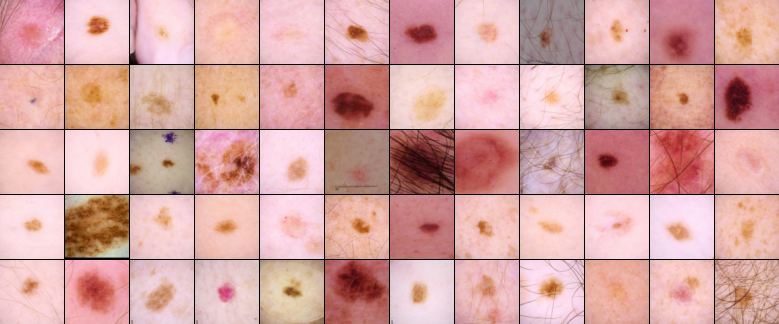

In [30]:
def show_dataset(thumb_size, cols, rows, ds):
    mosaic = PIL.Image.new(mode='RGB', size=(thumb_size*cols + (cols-1), 
                                             thumb_size*rows + (rows-1)))
   
    for idx, data in enumerate(iter(ds)):
        img, target_or_imgid = data
        ix  = idx % cols
        iy  = idx // cols
        img = np.clip(img.numpy() * 255, 0, 255).astype(np.uint8)
        img = PIL.Image.fromarray(img)
        img = img.resize((thumb_size, thumb_size), resample=PIL.Image.BILINEAR)
        mosaic.paste(img, (ix*thumb_size + ix, 
                           iy*thumb_size + iy))

    display(mosaic)
    
ds = get_dataset(files_train, CFG).unbatch().take(12*5)   
show_dataset(64, 12, 5, ds)

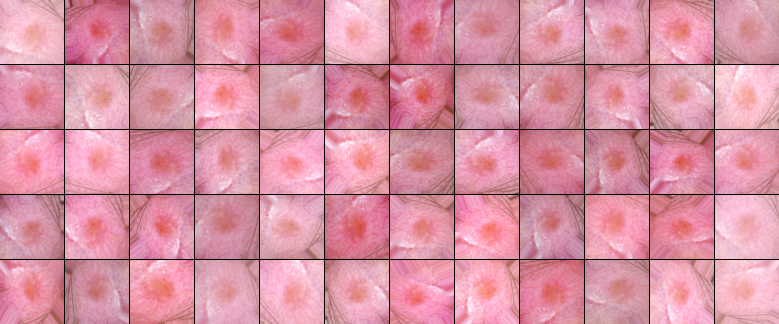

In [31]:
ds = tf.data.TFRecordDataset(files_train, num_parallel_reads=AUTO)
ds = ds.take(1).cache().repeat()
ds = ds.map(read_labeled_tfrecord, num_parallel_calls=AUTO)
ds = ds.map(lambda img, target: (prepare_image(img, cfg=CFG, augment=True), target), 
            num_parallel_calls=AUTO)
ds = ds.take(12*5)
ds = ds.prefetch(AUTO)

show_dataset(64, 12, 5, ds)

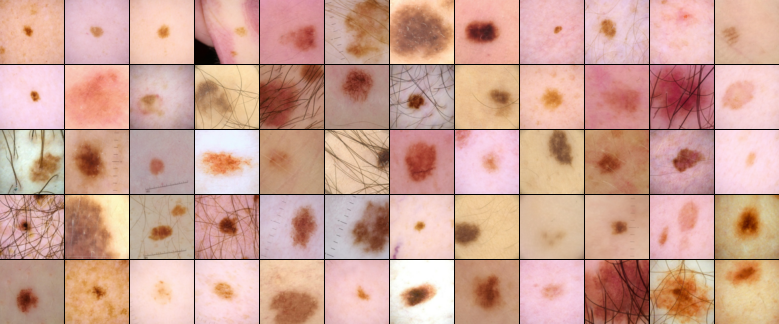

In [32]:
ds = get_dataset(files_test, CFG, labeled=False).unbatch().take(12*5)   
show_dataset(64, 12, 5, ds)

In [33]:
def get_lr_callback(cfg):
    lr_start   = cfg['LR_START']
    lr_max     = cfg['LR_MAX'] * strategy.num_replicas_in_sync
    lr_min     = cfg['LR_MIN']
    lr_ramp_ep = cfg['LR_RAMPUP_EPOCHS']
    lr_sus_ep  = cfg['LR_SUSTAIN_EPOCHS']
    lr_decay   = cfg['LR_EXP_DECAY']
   
    def lrfn(epoch):
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
            
        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max
            
        else:
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
            
        return lr

    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=False)
    return lr_callback

In [34]:
def get_model(cfg):
    model_input = tf.keras.Input(shape=(cfg['net_size'], cfg['net_size'], 3), name='imgIn')

    dummy = tf.keras.layers.Lambda(lambda x:x)(model_input)
    
    outputs = []    
    for i in range(cfg['net_count']):
        constructor = getattr(efn, f'EfficientNetB{i}')
        
        x = constructor(include_top=False, weights='imagenet', 
                        input_shape=(cfg['net_size'], cfg['net_size'], 3), 
                        pooling='avg')(dummy)
        
        x = tf.keras.layers.Dense(1, activation='sigmoid')(x)
        outputs.append(x)
        
    model = tf.keras.Model(model_input, outputs, name='aNetwork')
    model.summary()
    return model

In [35]:
def compile_new_model(cfg):    
    with strategy.scope():
        model = get_model(cfg)
     
        losses = [tf.keras.losses.BinaryCrossentropy(label_smoothing = cfg['label_smooth_fac'])
                  for i in range(cfg['net_count'])]
        
        model.compile(
            optimizer = cfg['optimizer'],
            loss      = losses,
            metrics   = [tf.keras.metrics.AUC(name='auc')])
        
    return model

In [36]:
ds_train     = get_dataset(files_train, CFG, augment=True, shuffle=True, repeat=True)
ds_train     = ds_train.map(lambda img, label: (img, tuple([label] * CFG['net_count'])))

steps_train  = count_data_items(files_train) / (CFG['batch_size'] * REPLICAS)

model        = compile_new_model(CFG)
history      = model.fit(ds_train, 
                         verbose          = 1,
                         steps_per_epoch  = steps_train, 
                         epochs           = CFG['epochs'],
                         callbacks        = [get_lr_callback(CFG)])

165527552/165527152 [==============================] - 3s 0us/step
Model: "aNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
imgIn (InputLayer)              [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 224, 224, 3)  0           imgIn[0][0]                      
__________________________________________________________________________________________________
efficientnet-b0 (Functional)    (None, 1280)         4049564     lambda[0][0]                     
__________________________________________________________________________________________________
efficientnet-b1 (Functional)    (None, 1280)         6575232     lambda[0][0]                     
________________________

In [37]:
CFG['batch_size'] = 256

cnt_test   = count_data_items(files_test)
steps      = cnt_test / (CFG['batch_size'] * REPLICAS) * CFG['tta_steps']
ds_testAug = get_dataset(files_test, CFG, augment=True, repeat=True, 
                         labeled=False, return_image_names=False)

probs = model.predict(ds_testAug, verbose=1, steps=steps)

probs = np.stack(probs)
probs = probs[:,:cnt_test * CFG['tta_steps']]
probs = np.stack(np.split(probs, CFG['tta_steps'], axis=1), axis=1)
probs = np.mean(probs, axis=1)

134/134 [==============================] - 314s 2s/step


In [38]:
ds = get_dataset(files_test, CFG, augment=False, repeat=False, 
                 labeled=False, return_image_names=True)

image_names = np.array([img_name.numpy().decode("utf-8") 
                        for img, img_name in iter(ds.unbatch())])

2021-11-28 00:53:28.763957: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 648007, Output num: 1
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1638060808.763730760","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 648007, Output num: 1","grpc_status":3}


In [39]:
for i in range(CFG["net_count"]):
    submission = pd.DataFrame(dict(
        image_name = image_names,
        target     = probs[i,:,0]))

    submission = submission.sort_values('image_name') 
    submission.to_csv(f'submission_model_{i}.csv', index=False)

In [40]:
submission = pd.DataFrame(dict(
    image_name = image_names,
    target     = np.mean(probs[:,:,0], axis=0)))

submission = submission.sort_values('image_name') 
submission.to_csv('submission_models_blended.csv', index=False)